# LSTM: LONG - SHORT TERM MEMORY
- run the HMM notebook to save data for this code's reference
   -  `Financial.Market.ML\1_Unsupervised\2-Hidden-Markov-Models-In-Practice.ipynb`

In [120]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Data extraction

In [121]:
df = pd.read_csv("data-storage\HMM-SPY.csv")
useful_features = ["Open", "Close", "12_MA" , "21_MA" ,  "HMM" , "lrets_bench" , "lrets_strat"  ]
df = df[useful_features]

df.head(2)

,Open,Close,12_MA,21_MA,HMM,lrets_bench,lrets_strat
0,467.890015,467.940002,472.971667,469.719048,1,-0.000940,0.000128
1,467.950012,466.089996,473.224167,469.555715,0,-0.003961,-0.000000


# Data Preprocessing

In [122]:
df["lrets_bench_rolling"] = df["lrets_bench"].rolling(window=10).mean()


# TARGET: PROJECT IF WE CAN PREDICT TOMORROWS LOGARITHMIC RETURNS
df["TARGET"] = df["lrets_strat"].shift(1)
df.dropna(inplace=True)
df.head()

,Open,Close,12_MA,21_MA,HMM,lrets_bench,lrets_strat,lrets_bench_rolling,TARGET
9,453.750000,446.750000,464.206665,468.203333,0,-0.011130,-0.0,-0.004728,-0.0
10,445.559998,437.980011,460.909167,467.009048,0,-0.019826,-0.0,-0.006617,-0.0
11,432.029999,439.839996,458.530833,465.682857,1,0.004238,0.0,-0.005797,-0.0
12,433.059998,434.470001,455.741666,463.962381,1,-0.012284,0.0,-0.006901,0.0
13,440.720001,433.380005,453.015834,461.872857,3,-0.002512,-0.0,-0.008059,0.0


In [123]:
# Identify non stationary columns 
non_stationaries = []
columns_with_constants = []

for col in df.columns:
    # Find variance in column numbers
    dftest = adfuller(df[col].values)
    
    # Get p-value
    p_value = dftest[1]
    
    # Perform t-test
    t_test = dftest[0] < dftest[4]["1%"]
    
    # Check if non stationary
    if p_value > 0.05  or not t_test:
        non_stationaries.append(col)

print(f"Non-Stationaries found:  {len(non_stationaries)}")
non_stationaries

Non-Stationaries found:  4


['Open', 'Close', '12_MA', '21_MA']

In [124]:
# Convert Non-Stationary items to logorithm
df[non_stationaries] =  np.log(df[non_stationaries])

In [125]:
# Min Max Scaling
scaler = MinMaxScaler()
df.iloc[: , :-1] = scaler.fit_transform(df.iloc[:,:-1])
df.head()

,Open,Close,12_MA,21_MA,HMM,lrets_bench,lrets_strat,lrets_bench_rolling,TARGET
9,0.947813,0.873720,1.000000,1.000000,0.000000,0.340227,0.608393,0.376253,-0.0
10,0.881888,0.796902,0.970475,0.989619,0.000000,0.251449,0.608393,0.289945,-0.0
11,0.770278,0.813322,0.949048,0.978061,0.333333,0.497113,0.608393,0.327414,-0.0
12,0.778897,0.765725,0.923778,0.963017,0.333333,0.328442,0.608393,0.276967,0.0
13,0.842357,0.755992,0.898932,0.944670,1.000000,0.428206,0.608393,0.224052,0.0


In [126]:
# Split x & y axis data
x_data = df.iloc[: , : -1].values
y_data = df.iloc[: , -1].values

# DATA SEQUENCING

In [127]:
def split_sequence(input_data , n_steps):
    X = list()
    
    for i in range(0 , len(input_data) , 1):
        
        # find the end of this pattern
        end_ix = i + n_steps

        # check if we are beyond the sequence
        if end_ix > len(input_data) -1 :
            break

        # Gather input and output parts of the pattern
        seq_x = input_data[i:end_ix, :-1]

        # gather input a
        X.append(seq_x)

    return np.array(X)


# STRUCTURING SEQUENCE ROLLING PREDICTION 
- feed the last 8 days and project what the 9th day `Y VALUE` will be
- then feed shift down one day and repeat 

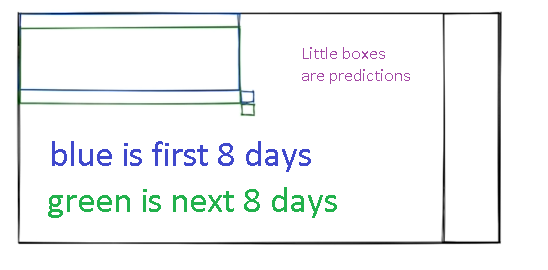

In [128]:
# Choose a number of time steps in each sample window
n_timesteps = 8

# split X into sequence samples 
X = split_sequence(x_data , n_timesteps)

# adjust y to start at the right point
y = y_data[n_timesteps: ]

# Torch DATASET structure class

In [129]:
# Dataset Class
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.length = self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length



# INIT DATA STRUCTURE WITH ROLLING PREDICTION MODEL
trainset = dataset(X , y)
trainloader = DataLoader(trainset , batch_size=64  , shuffle=False)

# CONSTRUCT NEURAL NETWORK

In [130]:
from torch import nn
from torch.autograd import Variable


class LSTM_Net(nn.Module):
    def __init__(self , input_dim, hidden_dim, layer_dim , output_dim):
        super(LSTM_Net , self).__init__()

        # Hidden Dimensions
        self.hidden_dim = hidden_dim

        # Hidden Layers
        self.layer_dim = layer_dim

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim , hidden_dim , layer_dim , batch_first=True)

        # Fully Connected Layer 1
        self.fc1 = nn.Linear(hidden_dim, 5)

        # Fully Connected Layer 2
        self.fc2 = nn.Linear(5 , output_dim)

    def forward(self, x):
        # INIT HIDDEN STATE WITH ZEROS (layer_dim = 1 , x.size = 64)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0) , self.hidden_dim))

        # INIT CELL STATE WITH ZEROS
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0) , self.hidden_dim))


        # CLASSIFICATION MODEL
        # out, (hn,cn) = self.lstm(x, (h0,c0))
        # out = self.fc1(out[: , -1, : ])
        # out = torch.sigmoid(self.fc2(out))

        # REGRESSION MODEL - Propagate input through LSTM
        ula , (h_out, _) = self.lstm(x, (h0,c0))
        h_out = h_out.view(-1,self.hidden_dim)
        out = self.fc1(h_out)
        out = self.fc2(out)

        return out

# IMPLEMENT NEURAL NNETWORK

In [131]:
# INIT MODEL
input_dim = X.shape[2]
hidden_dim = 100
layer_dim = 1
output_dim = 1
model = LSTM_Net( input_dim, hidden_dim, layer_dim , output_dim)

In [132]:
# review model structure
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

print("Amount of model params: ", len(list(model.parameters())))

torch.Size([400, 7])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([5, 100])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
Amount of model params:  8


# TRAIN LSTM Neural Network

In [134]:
epochs = 1000

# # CLASSIFICATION (binary cross entropy loss)
# criterion = nn.BCELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=le-1)


# REGRESSION (mean squared error)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.AdamW(model.parameters() , lr = 1e-1) 


iter = 0
losses = []
for epoch in range(0 , epochs , 1):
    for i , (X_train, y_train) in enumerate(trainloader):

        # Clear Gradients 
        optimizer.zero_grad()

        # Forward Pass
        outputs = model(X_train)

        # Calculate Loss 
        loss = criterion(outputs, y_train.unsqueeze(dim=1))

        # Backwards Propegation
        loss.backward()

        # Updating Parameters 
        optimizer.step()

    # TRACK PROGRESS
    if iter % 100 == 0:
        print("Loss" , loss)
        losses.append(loss.detach())

Loss tensor(0.0037, grad_fn=<MseLossBackward0>)
Loss tensor(0.0086, grad_fn=<MseLossBackward0>)
Loss tensor(0.0216, grad_fn=<MseLossBackward0>)
Loss tensor(0.0033, grad_fn=<MseLossBackward0>)
Loss tensor(0.0019, grad_fn=<MseLossBackward0>)
Loss tensor(0.0016, grad_fn=<MseLossBackward0>)
Loss tensor(0.0117, grad_fn=<MseLossBackward0>)
Loss tensor(0.0116, grad_fn=<MseLossBackward0>)
Loss tensor(0.0221, grad_fn=<MseLossBackward0>)
Loss tensor(0.0005, grad_fn=<MseLossBackward0>)
Loss tensor(0.0631, grad_fn=<MseLossBackward0>)
Loss tensor(0.0025, grad_fn=<MseLossBackward0>)
Loss tensor(0.0006, grad_fn=<MseLossBackward0>)
Loss tensor(0.0004, grad_fn=<MseLossBackward0>)
Loss tensor(0.0003, grad_fn=<MseLossBackward0>)
Loss tensor(2.2452e-05, grad_fn=<MseLossBackward0>)
Loss tensor(0.0009, grad_fn=<MseLossBackward0>)
Loss tensor(0.0019, grad_fn=<MseLossBackward0>)
Loss tensor(0.0002, grad_fn=<MseLossBackward0>)
Loss tensor(0.0005, grad_fn=<MseLossBackward0>)
Loss tensor(0.0003, grad_fn=<MseLoss

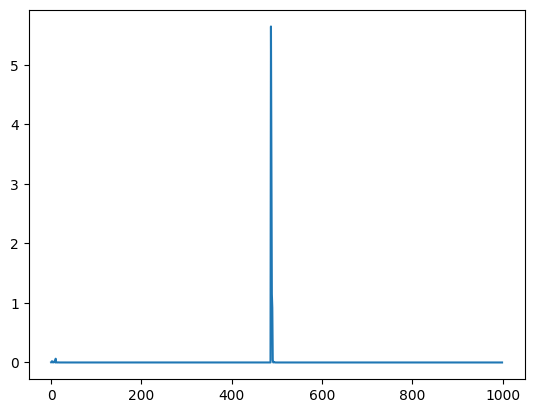

In [135]:
# VISUALIZE LOSSES 
plt.plot(losses)
plt.show()